In [ ]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier)
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split, RandomizedSearchCV
import optuna
from imblearn.over_sampling import SMOTE

In [2]:
# Загружаем данные
data = pd.read_csv('data/si_data.csv')

Для выполнения задания необходимо создать бинарный столбец, который будет показывать, превышает ли значение в столбце SI число 8. Этот столбец станет целевой переменной для задачи классификации.

In [ ]:
# Преобразуем число "8" через log1p так как в оригинальном датасете мы также модицифировали данные
threshold = np.log1p(8)

# Создаем бинарный столбец, показывающий, больше ли значение SI_log числа 8
data['SI_log_binary'] = (data['SI_log'] > threshold).astype(int)

# Убираем переменную, на основе которой был создан бинарный целевой признак
data = data.drop(columns=['SI_log'])

Перед тем как приступить к дальнейшей работе, необходимо проверить баланс классов.

In [4]:
# Проверяем баланс классов
print(data['SI_log_binary'].value_counts())
print(data['SI_log_binary'].value_counts(normalize=True))

SI_log_binary
0    603
1    326
Name: count, dtype: int64
SI_log_binary
0    0.649085
1    0.350915
Name: proportion, dtype: float64


В исходных данных наблюдается дисбаланс классов: класс 0 встречается почти в два раза чаще, чем класс 1 (65% против 35%). Это может привести к смещению моделей в сторону преобладающего класса и занижению качества классификации по редкому классу.

In [5]:
# Разделяем данные и убираем целевую переменную
X = data.drop(columns=['SI_log_binary'])
y = data['SI_log_binary']

В условиях ограниченного количества данных и выраженного дисбаланса классов использование оригинального или уменьшенного датасета нецелесообразно. Oversampling позволяет сохранить все доступные данные и сбалансировать классы, улучшая способность модели обнаруживать миноритарный класс. Поэтому именно этот подход был выбран без необходимости дополнительного сравнения.

In [ ]:
# Разбиение без изменений (70% тренировочные, 30% тестовые)
X_base_train, X_test, y_base_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Oversampling
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_base_train, y_base_train)

Проверим баланс классов после oversampling:

In [7]:
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))

SI_log_binary
1    422
0    422
Name: count, dtype: int64
SI_log_binary
1    0.5
0    0.5
Name: proportion, dtype: float64


После применения oversampling баланс был выровнен: доли классов стали равными (50/50).

In [8]:
# Инициализация моделей со стандартными параметрами
models = {
    'XGBoost': XGBClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'HistGradient Boosting': HistGradientBoostingClassifier(random_state=42, loss='log_loss'),
    'Extra Trees': ExtraTreesClassifier(random_state=42),
}

In [9]:
# Функция для оценки моделей
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Оценивает классификационную модель и возвращает accuracy и F1-score"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return {
        'Accuracy': round(accuracy_score(y_test, y_pred), 4),
        'F1-score': round(f1_score(y_test, y_pred), 4),
        'Precision': round(precision_score(y_test, y_pred), 4),
        'Recall': round(recall_score(y_test, y_pred), 4),
    }

In [10]:
# Оценка базовых моделей (без подбора параметров)
base_results = []
for name, model in models.items():
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
    base_results.append({
        'Model': name,
        **metrics,
        'Hyperparametres': False
    })
    
base_results = pd.DataFrame(base_results)
display(base_results.sort_values('Accuracy', ascending=False))

,Model,Accuracy,F1-score,Precision,Recall,Hyperparametres
0,XGBoost,0.7025,0.5202,0.6000,0.4592,False
2,CatBoost,0.7025,0.5146,0.6027,0.4490,False
1,Random Forest,0.6882,0.5085,0.5696,0.4592,False
3,Gradient Boosting,0.6846,0.5111,0.5610,0.4694,False
5,Extra Trees,0.6846,0.5056,0.5625,0.4592,False
4,HistGradient Boosting,0.6810,0.5189,0.5517,0.4898,False


Модели обучались с использованием базовых параметров. Наилучший результат Accuracy показали модели XGBoost и CatBoost — 0.7025. Остальные модели показали схожие, но немного более низкие результаты.

In [ ]:
"""
Определяем словарь param_grid с диапазонами гиперпараметров для каждой модели.
- Числовые параметры задаются как кортеж (min, max) и:
  - преобразуются в списки при использовании RandomizedSearchCV,
  - или напрямую используются в Optuna для проб в указанных границах.
- Категориальные параметры задаются списками (например: ['sqrt', 'log2', None]).
Словарь используется для автоматического подбора параметров с помощью разных стратегий оптимизации.
"""

param_grid = {
    'XGBoost': {
        'n_estimators': (100, 800),
        'max_depth': (2, 15),
        'learning_rate': (0.01, 0.5),
        'subsample': (0.2, 1.0),
        'colsample_bytree': (0.2, 1.0),
        'gamma': (0.0, 5.0),
        'min_child_weight': (1, 10),
    },

    'Random Forest': {
        'n_estimators': (100, 300),
        'max_depth': (4, 20),
        'min_samples_split': (2, 18),
        'min_samples_leaf': (1, 18),
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True],
    },

    'CatBoost': {
        'iterations': (150, 1000),
        'depth': (4, 12),
        'learning_rate': (0.01, 0.3),
        'l2_leaf_reg': (1, 10),
        'border_count': [64, 128, 255],
        'bagging_temperature': (0.0, 1.0),
        'verbose': [False],
    },

    'Gradient Boosting': {
        'n_estimators': (100, 300),
        'learning_rate': (0.01, 0.3),
        'max_depth': (3, 10),
        'min_samples_split': (2, 18),
        'min_samples_leaf': (1, 18),
        'max_features': ['sqrt', 'log2', None],
        'subsample': (0.5, 1.0),
    },

    'HistGradient Boosting': {
        'max_iter': (100, 300),
        'learning_rate': (0.01, 0.3),
        'max_depth': (3, 11),
        'min_samples_leaf': (1, 25),
        'l2_regularization': (0.0, 1.0),
        'max_bins': [64, 128, 255],
    },

    'Extra Trees': {
        'n_estimators': (100, 300),
        'max_depth': (4, 20),
        'min_samples_split': (2, 18),
        'min_samples_leaf': (1, 18),
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True],
    }
}

In [ ]:
def convert_grid_for_random_search(grid, n_points=3):
    """
    Преобразует сетку гиперпараметров с диапазонами (кортежи) в списки значений для RandomizedSearchCV.
    - Если параметр задан диапазоном (tuple), генерирует n_points равномерно распределённых значений.
    - Если параметр уже список, оставляет без изменений.
    """
    rs_grid = {}
    for param, vals in grid.items():
        if isinstance(vals, tuple):
            # Диапазон: генерируем n_points значений (int или float)
            if all(isinstance(v, int) for v in vals):
                rs_grid[param] = list(np.linspace(vals[0], vals[1], n_points, dtype=int))
            else:
                rs_grid[param] = list(np.linspace(vals[0], vals[1], n_points))
        elif isinstance(vals, list):
            rs_grid[param] = vals
        else:
            raise ValueError(f"Unknown param type for {param}: {vals}")
    return rs_grid

# Перебор моделей и подбор гиперпараметров с RandomizedSearchCV, используя преобразованную сетку параметров
tuned_results = []
for name in models.keys():
    # Преобразуем сетку из диапазонов в списки для RandomizedSearchCV
    rs_params = convert_grid_for_random_search(param_grid[name], n_points=3)

    search = RandomizedSearchCV(
        estimator=models[name],
        param_distributions=rs_params,
        n_iter=20,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)

    metrics = evaluate_model(search.best_estimator_, X_train, y_train, X_test, y_test)
    tuned_results.append({
        'Model': name,
        **metrics,
        'Hyperparametres': True
    })

tuned_results = pd.DataFrame(tuned_results)
display(tuned_results.sort_values('Accuracy', ascending=False))

,Model,Accuracy,F1-score,Precision,Recall,Hyperparametres
4,HistGradient Boosting,0.6989,0.5116,0.5946,0.4490,True
3,Gradient Boosting,0.6810,0.4795,0.5616,0.4184,True
5,Extra Trees,0.6810,0.5083,0.5542,0.4694,True
2,CatBoost,0.6774,0.5213,0.5444,0.5000,True
1,Random Forest,0.6738,0.4740,0.5467,0.4184,True
0,XGBoost,0.6487,0.4432,0.5000,0.3980,True


После настройки гиперпараметров произошло небольшое улучшение. CatBoost сохранил лучшие метрики F1-score и Recall, в то время как XGBoost продемонстрировал ухудшение по всем показателям. Некоторые модели, такие как Extra Trees и HistGradient Boosting, показали улучшение Precision, но не F1.

In [13]:
# Объединение результатов
all_results = pd.concat([base_results, tuned_results])

# Вывод таблицы
display(all_results.sort_values('Accuracy', ascending=False))

,Model,Accuracy,F1-score,Precision,Recall,Hyperparametres
0,XGBoost,0.7025,0.5202,0.6000,0.4592,False
2,CatBoost,0.7025,0.5146,0.6027,0.4490,False
4,HistGradient Boosting,0.6989,0.5116,0.5946,0.4490,True
1,Random Forest,0.6882,0.5085,0.5696,0.4592,False
3,Gradient Boosting,0.6846,0.5111,0.5610,0.4694,False
5,Extra Trees,0.6846,0.5056,0.5625,0.4592,False
4,HistGradient Boosting,0.6810,0.5189,0.5517,0.4898,False
3,Gradient Boosting,0.6810,0.4795,0.5616,0.4184,True
5,Extra Trees,0.6810,0.5083,0.5542,0.4694,True
2,CatBoost,0.6774,0.5213,0.5444,0.5000,True


Из сводной таблицы видно, что наилучшие результаты до настройки гиперпараметров показала модель XGBoost (Accuracy = 0.7025), однако после настройки её качество снизилось по всем метрикам, особенно по Recall. В то же время CatBoost, напротив, улучшил F1-score и Recall после подбора параметров, хотя Accuracy незначительно просело. Также заметно, что улучшения от настройки параметров были в целом умеренными для всех моделей.

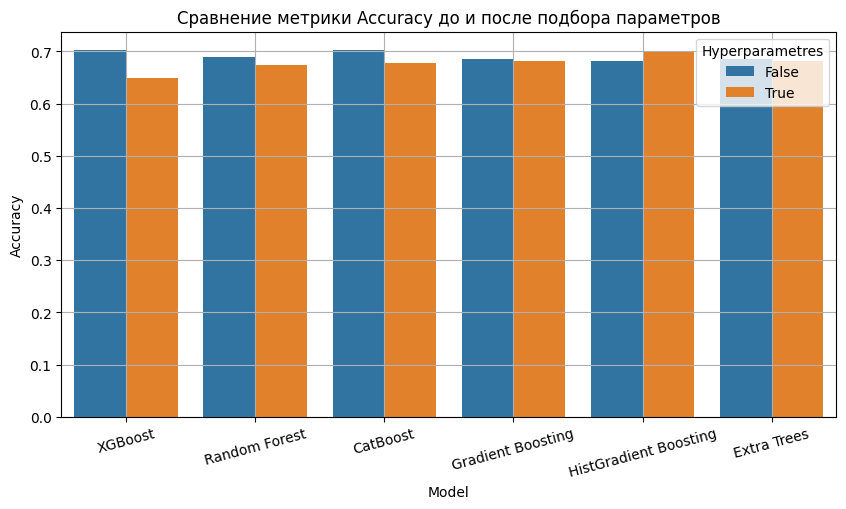

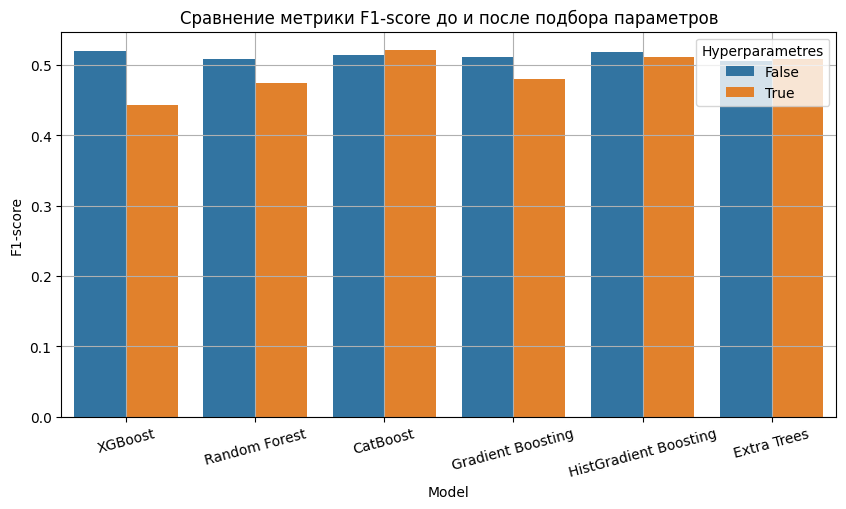

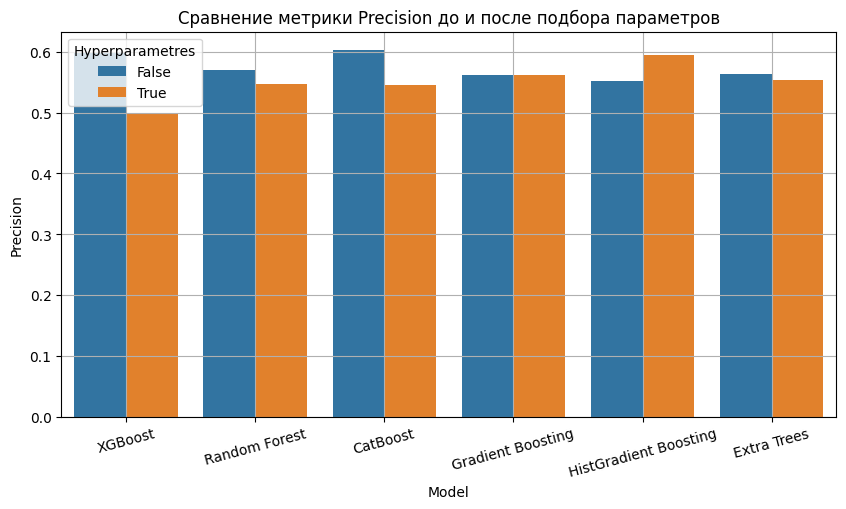

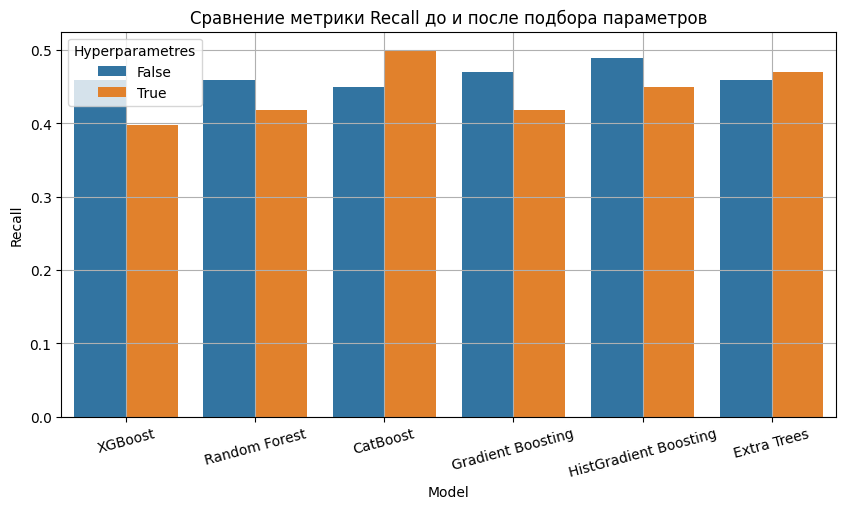

In [ ]:
# Визуализация сравнения моделей по метрикам (Accuracy, F1-score, Precision, Recall) до и после подбора гиперпараметров
metrics_to_plot = ['Accuracy', 'F1-score', 'Precision', 'Recall']

for metric in metrics_to_plot:
    plt.figure(figsize=(10, 5))
    sns.barplot(data=all_results, x='Model', y=metric, hue='Hyperparametres')
    plt.title(f'Сравнение метрики {metric} до и после подбора параметров')
    plt.ylabel(metric)
    plt.xticks(rotation=15)
    plt.grid(True)
    plt.show()


In [ ]:
# Анализ результатов: определение лучших и худших моделей по метрикам, выбор модели с минимальным RMSE и выявление моделей, у которых тюнинг не дал улучшений
tuned_only = all_results[all_results['Hyperparametres'] == True].copy()
baseline = all_results[all_results['Hyperparametres'] == False].copy()

# Модель, выбранная для дальнейшей оптимизации
chosen_model = all_results.sort_values('Accuracy', ascending=False).iloc[0]['Model']

# Проход по метрикам
for metric in ['Accuracy', 'F1-score', 'Precision', 'Recall']:
    print(f"\nМетрика: {metric}")

    ascending = False

    best_model = all_results.sort_values(metric, ascending=ascending).iloc[0]
    worst_model = all_results.sort_values(metric, ascending=not ascending).iloc[0]

    print(f"Лучшая модель: **{best_model['Model']}** → {metric} = {best_model[metric]:.4f}")
    print(f"Худшая модель: **{worst_model['Model']}** → {metric} = {worst_model[metric]:.4f}")

    # Сравнение тюнингованных с базовыми версиями
    merged = tuned_only.merge(
        baseline,
        on='Model',
        suffixes=('_tuned', '_base')
    ).drop_duplicates('Model')

    stagnant = merged[merged[f'{metric}_tuned'] <= merged[f'{metric}_base']]['Model'].tolist()

    if stagnant:
        print(f"Без улучшений или хуже: {', '.join(sorted(set(stagnant)))}")


Метрика: Accuracy
Лучшая модель: **XGBoost** → Accuracy = 0.7025
Худшая модель: **XGBoost** → Accuracy = 0.6487
Без улучшений или хуже: CatBoost, Extra Trees, Gradient Boosting, Random Forest, XGBoost

Метрика: F1-score
Лучшая модель: **CatBoost** → F1-score = 0.5213
Худшая модель: **XGBoost** → F1-score = 0.4432
Без улучшений или хуже: Gradient Boosting, HistGradient Boosting, Random Forest, XGBoost

Метрика: Precision
Лучшая модель: **CatBoost** → Precision = 0.6027
Худшая модель: **XGBoost** → Precision = 0.5000
Без улучшений или хуже: CatBoost, Extra Trees, Random Forest, XGBoost

Метрика: Recall
Лучшая модель: **CatBoost** → Recall = 0.5000
Худшая модель: **XGBoost** → Recall = 0.3980
Без улучшений или хуже: Gradient Boosting, HistGradient Boosting, Random Forest, XGBoost


In [ ]:
"""
Оптимизация гиперпараметров лучшей модели с помощью Optuna:

1. Определяем лучшую модель по метрике RMSE из предыдущих результатов.
2. Задаём пространство поиска гиперпараметров, учитывая типы.
3. Запускаем Optuna для минимизации RMSE с 5-fold кросс-валидацией.
4. Обучаем финальную модель на оптимальных параметрах.
5. Вычисляем и выводим метрики качества на тесте.
6. Сравниваем финальный результат с предыдущей лучшей версией модели.
"""

# Выбираем лучшую модель
best_model_name = all_results.sort_values('Accuracy', ascending=False).iloc[0]['Model']
print(f"Лучшая модель: {best_model_name}")

model_class = models[best_model_name]
param_space = param_grid[best_model_name]

def objective(trial):
    params = {}
    for param, values in param_space.items():
        # Если диапазон (tuple), предполагаем [min, max]
        if isinstance(values, tuple) and len(values) == 2:
            low, high = values
            if isinstance(low, int) and isinstance(high, int):
                params[param] = trial.suggest_int(param, low, high)
            else:
                params[param] = trial.suggest_float(param, low, high)
        # Если список, то категориальный параметр
        elif isinstance(values, list):
            # Если это список с bool или str/None - categorical
            if all(isinstance(v, bool) for v in values) or all(isinstance(v, (str,type(None))) for v in values):
                params[param] = trial.suggest_categorical(param, values)
            # Если числа — тоже categorical (например дискретные значения)
            elif all(isinstance(v, (int,float)) for v in values):
                params[param] = trial.suggest_categorical(param, values)
            else:
                raise ValueError(f"Unsupported list param type for '{param}': {values}")
        else:
            raise ValueError(f"Unsupported param format for '{param}': {values}")

    params['random_state'] = 42

    model = model_class.__class__(**params)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    accuracy = cross_val_score(model, X_train, y_train,
                               scoring='accuracy', cv=cv, n_jobs=-1).mean()
    return accuracy

print(f"\nЗапуск Optuna для {best_model_name}...")
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100, show_progress_bar=True)

print(f"\nЛучшие параметры:")
print(study.best_params)

final_model = model_class.__class__(**study.best_params, random_state=42)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

final_accuracy = accuracy_score(y_test, y_pred)
final_f1 = f1_score(y_test, y_pred)
final_precision = precision_score(y_test, y_pred)
final_recall = recall_score(y_test, y_pred)

print("\nФинальные метрики:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"F1-score: {final_f1:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")

prev_versions = all_results[all_results['Model'] == best_model_name]
prev_best = prev_versions.sort_values('Accuracy', ascending=False).iloc[0]

print("\nСравнение с предыдущей лучшей версией этой модели (до Optuna):")
print(f"Accuracy было: {prev_best['Accuracy']:.4f} → стало: {final_accuracy:.4f}")
print(f"Улучшение: {final_accuracy - prev_best['Accuracy']:.4f}")
print(f"F1-score было: {prev_best['F1-score']:.4f} → стало: {final_f1:.4f}")
print(f"Улучшение: {final_f1 - prev_best['F1-score']:.4f}")

[I 2025-07-29 01:30:12,149] A new study created in memory with name: no-name-128ee088-4abd-458e-8663-cf7c7891bb49


Лучшая модель: XGBoost

Запуск Optuna для XGBoost...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-29 01:30:12,748] Trial 0 finished with value: 0.7322696534234996 and parameters: {'n_estimators': 685, 'max_depth': 3, 'learning_rate': 0.3748738360229637, 'subsample': 0.4884006690050286, 'colsample_bytree': 0.48744867024645755, 'gamma': 3.0461919030907585, 'min_child_weight': 4}. Best is trial 0 with value: 0.7322696534234996.
[I 2025-07-29 01:30:13,214] Trial 1 finished with value: 0.7370245139475908 and parameters: {'n_estimators': 386, 'max_depth': 9, 'learning_rate': 0.357972516730266, 'subsample': 0.9684209801645338, 'colsample_bytree': 0.5652968871511499, 'gamma': 2.138257605308045, 'min_child_weight': 2}. Best is trial 1 with value: 0.7370245139475908.
[I 2025-07-29 01:30:13,585] Trial 2 finished with value: 0.7370245139475908 and parameters: {'n_estimators': 252, 'max_depth': 15, 'learning_rate': 0.4722418529981536, 'subsample': 0.9054594249251982, 'colsample_bytree': 0.7171284499227149, 'gamma': 1.0691240606530428, 'min_child_weight': 7}. Best is trial 1 with valu

Оптимизация гиперпараметров с использованием Optuna позволила достичь умеренного улучшения по метрике Accuracy (до 0.7097). Однако метрика F1-score практически не изменилась (увеличение на 0.0005).

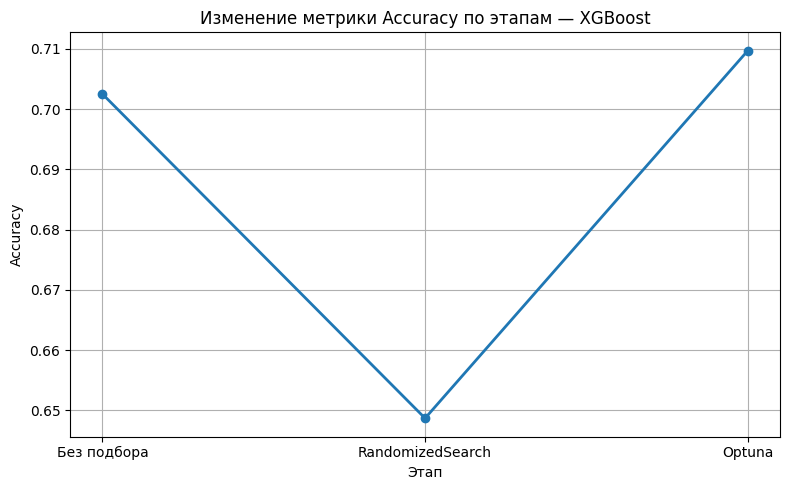

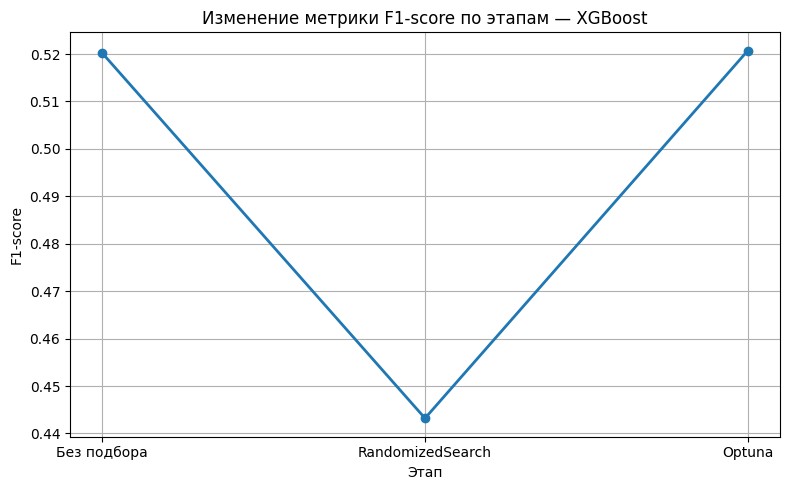

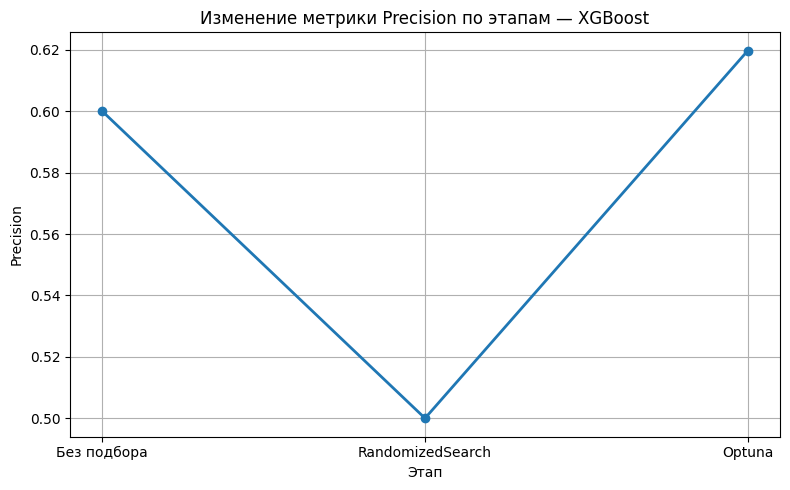

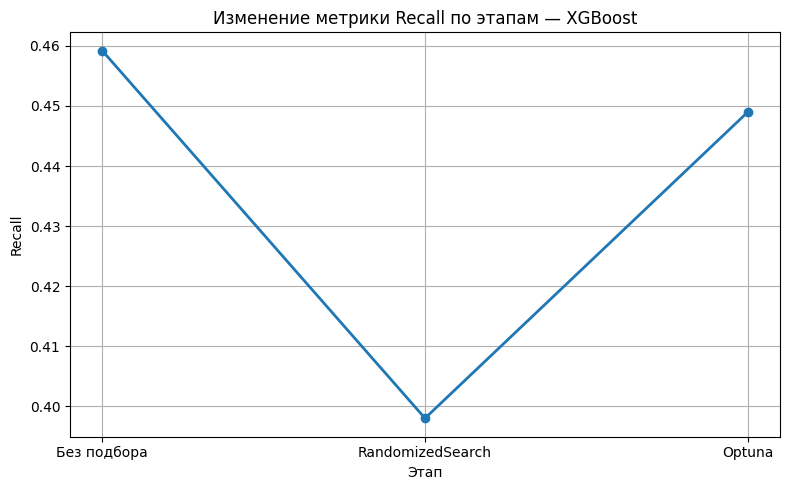

In [ ]:
target_model = best_model_name

# 1. Получаем базовую версию (без подбора)
base_row = all_results[(all_results['Model'] == target_model) & (all_results['Hyperparametres'] == False)].sort_values('Accuracy', ascending=False).iloc[0]

# 2. С RandomizedSearch
random_row = all_results[(all_results['Model'] == target_model) & (all_results['Hyperparametres'] == True)].sort_values('Accuracy', ascending=False).iloc[0]

# 3. Финальные метрики Optuna (берём из переменных после обучения)
optuna_metrics = {
    'Accuracy': final_accuracy,
    'F1-score': final_f1,
    'Precision': final_precision,
    'Recall': final_recall
}

# 4. Собираем всё в DataFrame
progress = pd.DataFrame({
    'Этап': ['Без подбора', 'RandomizedSearch', 'Optuna'],
    'Accuracy': [base_row['Accuracy'], random_row['Accuracy'], optuna_metrics['Accuracy']],
    'F1-score': [base_row['F1-score'], random_row['F1-score'], optuna_metrics['F1-score']],
    'Precision': [base_row['Precision'], random_row['Precision'], optuna_metrics['Precision']],
    'Recall': [base_row['Recall'], random_row['Recall'], optuna_metrics['Recall']],
})

# 5. Строим графики для каждой метрики
for metric in ['Accuracy', 'F1-score', 'Precision', 'Recall']:
    plt.figure(figsize=(8, 5))
    plt.plot(progress['Этап'], progress[metric], marker='o', linewidth=2)
    plt.title(f'Изменение метрики {metric} по этапам — {target_model}')
    plt.xlabel('Этап')
    plt.ylabel(metric)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Исходя из анализа, оптимальной моделью для классификации превышения значения в столбце SI числа 8 является XGBoost с настройкой гиперпараметров через Optuna. Модель демонстрирует высокую точность и сбалансированность между полнотой и точностью, что важно для надёжного предсказания.